# Лабораторна робота No6. Виявлення об’єктiв (object detection) на вiдео та зображеннях

1. Підготувати середовище

In [1]:
import random
import numpy as np
import tensorflow as tf
import keras_cv

from src.conf.cv_config import load_config
from src.data.udacity import download_udacity_dataset, create_udacity_ds
from src.visualization.image import sample_obj_detection_dataset, visualize_detections
from src.visualization.plot import plot_loss_and_val_loss
from src.definitions import MODELS_FOLDER
from lib.metrics.coco_metrics import EvaluateCOCOMetricsCallback

random_seed = 42

tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

conf = load_config()

Using TensorFlow backend


2. Обрати будь-який датасет

In [2]:
path = download_udacity_dataset(conf)
train_ds, test_ds, class_mapping, box_format = create_udacity_ds(path)

print(f"Train dataset size: {len(train_ds)} batches")
print(f"Train dataset size: {len(test_ds)} batches")

loading Roboflow workspace...
loading Roboflow project...


2025-01-07 01:16:33.115692: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-01-07 01:16:33.115721: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2025-01-07 01:16:33.115727: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2025-01-07 01:16:33.115775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-07 01:16:33.115798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Train dataset size: 422 batches
Train dataset size: 46 batches


2025-01-07 01:16:43.309412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


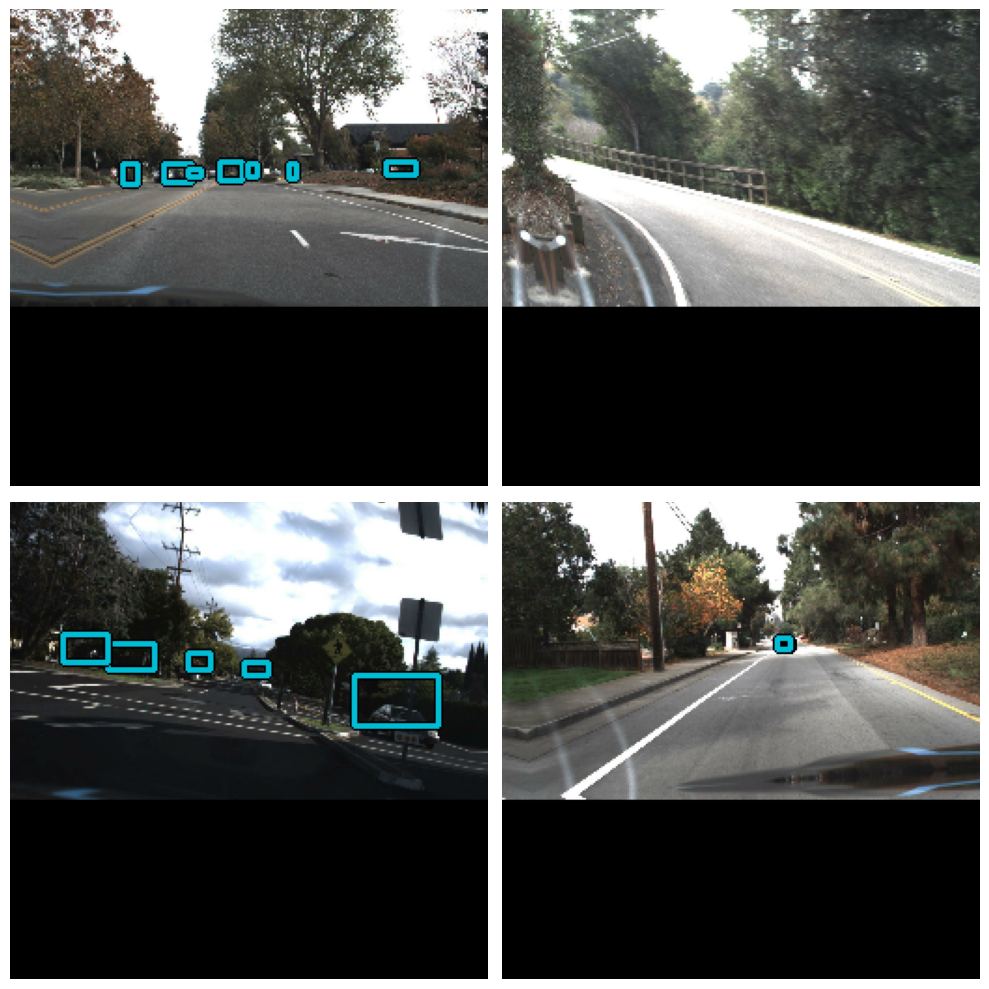

In [3]:
sample_obj_detection_dataset(
    train_ds,
    bounding_box_format=box_format,
    value_range=(0, 255),
    rows=2,
    cols=2,
    class_mapping=class_mapping,
)

3. Реалiзувати базову модель власноруч (за бажанням) або встановити одну з моделей YOLO (v8, v9 або v10)

In [4]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco" 
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format=box_format,
    backbone=backbone,
    fpn_depth=1,
)

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.01,
    global_clipnorm=10,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


4. Попередньо обробити та пiдоготувати датасет для обраної моделi YOLO.

In [5]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

5. Навчити обрану модель на датасетi.

In [ ]:
train_feedback = yolo.fit(
    train_ds,
    validation_data=test_ds,
    epochs=1,
    callbacks=[EvaluateCOCOMetricsCallback(test_ds, MODELS_FOLDER / "detect-yolo.h5")],
)

6. Проаналiзувати графiки навчання, точностi.

In [ ]:
plot_loss_and_val_loss(train_feedback)

7. Пiдготувати декiлька прикладiв знаходження об’єктiв на зображеннях з датасету чи на вiдео.

In [ ]:
visualize_detections(
    yolo, dataset=train_ds, bounding_box_format=box_format, class_mapping=class_mapping
)